<a href="https://colab.research.google.com/github/yeb2Binfang/DS_GY_3001_CV/blob/main/HW/HW2/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2: Canny edge detector

**Due date:** October 15th 2019

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

**Load and visualize image**

--2021-03-10 02:15:11--  https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105764 (103K) [image/jpeg]
Saving to: ‘lena.jpg’

lena.jpg            100%[===================>] 103.29K  --.-KB/s    in 0.03s   

2021-03-10 02:15:11 (3.92 MB/s) - ‘lena.jpg’ saved [105764/105764]



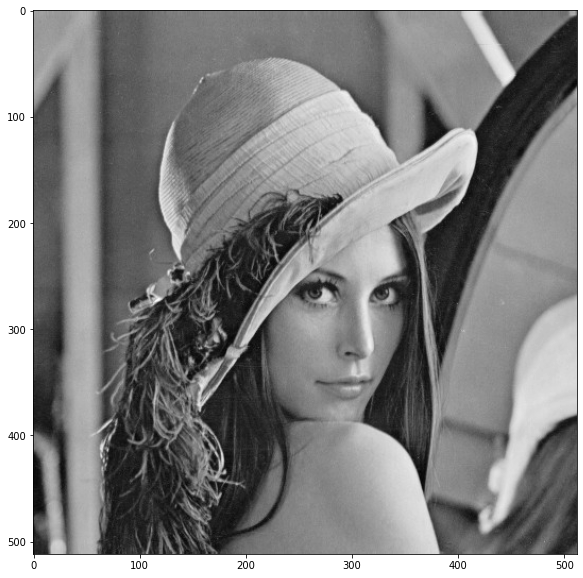

In [114]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
# get image
!wget https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg -O lena.jpg
name = './lena.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

**Detailed instructions:**

https://www.cnblogs.com/king-lps/p/8007134.html

a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

steps:
Explain the reason why we need to remove the noise

In [135]:
import cv2
img_remove = cv2.GaussianBlur(img,(3,3),0) # Apply Gaussian filter to remove noise

compare the spectrogram

In [5]:
def get_spectrogram(img):
  ## must be grey image
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  fimg = np.log(np.abs(fshift))
  plt.imshow(fimg, 'gray')

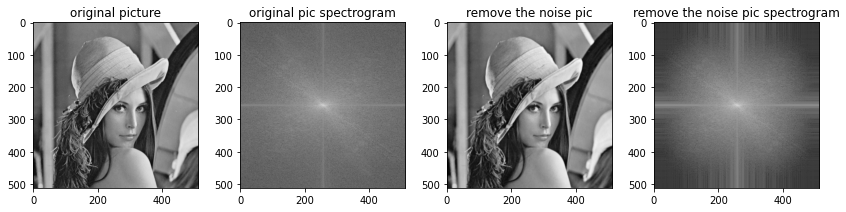

In [136]:
plt.figure(figsize=(12,8))

plt.subplot(141)
plt.imshow(img)
plt.title('original picture')

plt.subplot(142)
get_spectrogram(img)
plt.title('original pic spectrogram')

plt.subplot(143)
plt.imshow(img_remove)
plt.title('remove the noise pic')

plt.subplot(144)
get_spectrogram(img_remove)
plt.title('remove the noise pic spectrogram')

plt.tight_layout()

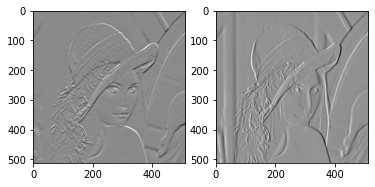

In [168]:
from scipy.ndimage import gaussian_filter
plt.subplot(121)
Gy=ndimage.gaussian_filter(img_remove, 1, (1,0))
plt.imshow(Gy)

plt.subplot(122)
Gx=ndimage.gaussian_filter(img_remove, 1, (0,1))
plt.imshow(Gx)



In [169]:
threshold = 1
G = np.sqrt(Gy**2 + Gx**2)
G1 = np.sqrt(Gy**2 + Gx**2)

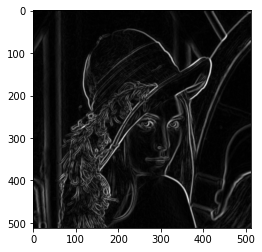

In [170]:
plt.imshow(G)

In [171]:
print(np.max(G))

55.12138501827205


In [172]:
## calculate the theta
import math
g_theta = np.arctan2(Gy,Gx)
gx,gy = g_theta.shape
theta = np.zeros((gx,gy))
for i in range(gx):
  for j in range(gy):
    theta[i][j] = math.degrees(g_theta[i][j])
print(np.min(theta))

-179.9988448001315


In [173]:
print(np.max(G))

55.12138501827205


In [174]:
m,n = G.shape
nms_img = np.zeros((m,n))
print(nms_img[0][0])

0.0


In [128]:
m,n = G.shape
nms_img = np.zeros((m,n))

# the reason why we do the range between [1,m-1], [1,n-1] because we do not want it out of index
for i in range(1,m-1):
  for j in range(1,n-1):
    nms_img[i][j] = 255

b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary image with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [175]:
def nms(G,theta):
  m,n = G.shape
  nms_img = G
  
  # the reason why we do the range between [1,m-1], [1,n-1] because we do not want it out of index
  for i in range(1,m-1):
    for j in range(1,n-1):
      # map to 0
      if (G[i][j]>1):
        if ((theta[i][j] >= -22.5 and theta[i][j] < 22.5) or (theta[i][j] <= -157.5 and theta[i][j] >= 157.5)):
          # make sure it is the largest
          if ((G[i][j] > G[i][j+1]) and (G[i][j] > G[i][j-1])):       
            nms_img[i][j] = G[i][j]
          else:
            # otherwise, set it as black
            nms_img[i][j] = 0

        # map to 45
        if ((theta[i][j] >= 22.5 and theta[i][j] < 67.5) or (theta[i][j] <= -112.5 and theta[i][j] > -157.5)):
          # make sure it is the largest
          if ((G[i][j] > G[i+1][j-1]) and (G[i][j] > G[i-1][j+1])):       
            nms_img[i][j] = G[i][j]
          else:
            # otherwise, set it as black
            nms_img[i][j] = 0

        # map to 90
        if ((theta[i][j] >= 67.5 and theta[i][j] < 112.5) or (theta[i][j] <= -67.5 and theta[i][j] > -112.5)):
          # make sure it is the largest
          if ((G[i][j] > G[i+1][j]) and (G[i][j] > G[i-1][j])):       
            nms_img[i][j] = G[i][j]
          else:
            # otherwise, set it as black
            nms_img[i][j] = 0

        # map to 135
        if ((theta[i][j] >= 112.5 and theta[i][j] < 157.5) or (theta[i][j] <= -22.5 and theta[i][j] > -67.5)):
          # make sure it is the largest
          if ((G[i][j] > G[i-1][j-1]) and (G[i][j] > G[i+1][j+1])):       
            nms_img[i][j] = G[i][j]
          else:
            # otherwise, set it as black
            nms_img[i][j] = 0
  return nms_img
      

In [176]:
res = nms(G1,theta)

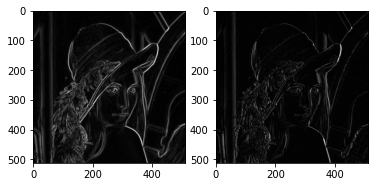

In [177]:
plt.subplot(121)
plt.imshow(G)
plt.subplot(122)
plt.imshow(res, cmap = plt.get_cmap('gray'))

In [90]:
print(np.max(res))

66.48366077472136


c- Combine step 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step 'c' with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.